# Лабораторная работа № 3 по дисциплине "Системы искусственного интеллекта"

## Задание лабораторной работы
0. Датасет:
    - [Датасет про диабет](https://www.kaggle.com/datasets/abdallamahgoub/diabetes/data)
1. Проведите предварительную обработку данных, включая обработку отсутствующих значений, кодирование категориальных признаков и масштабирование.
2. Получите и визуализируйте (графически) статистику по датасету (включая количество, среднее значение, стандартное отклонение, минимум, максимум и различные квантили), постройте 3d-визуализацию признаков.
3. Реализуйте метод k-ближайших соседей без использования сторонних библиотек, кроме NumPy и Pandas.
4. Постройте две модели k-NN с различными наборами признаков:
    - Модель 1: Признаки случайно отбираются.
    - Модель 2: Фиксированный набор признаков, который выбирается заранее.
5. Для каждой модели проведите оценку на тестовом наборе данных при разных значениях k. Выберите несколько различных значений k, например, k=3, k=5, k=10, и т. д. Постройте матрицу ошибок.

## Выполнение лабораторной работы
### 0. Установка и импорт библиотек, загрузка датасета

Сначала установим библиотеки, если они уже не установлены.

In [119]:
!pip install numpy pandas matplotlib seaborn


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Импортируем необходимые библиотеки.

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Загрузим датасет и выведем основную статистику по нему и 5 первых строк:

In [121]:
data = pd.read_csv('diabetes.csv')
print(data.describe())
data.head()

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI    Pedigree         Age     Outcome  
count  768.000000  768.000000  768.000000  768.000000  
mean    31.992578    0.471876   33.240885    0.348958  
std      7.884160    0.331329   11.760232    0.476951  
min      0.000000    0.078000   21.000000    0.000000  
25%     27.300000    0.243750   24.

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Pedigree,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### 1. Обработка значений

#### 1.1. Фильтрация отсутствующих значений

Проверим наличие рядов с отсутствующими значениями. Удалим строки с пропущенными значениями:

In [122]:
missing_values = data.isnull().sum()
print("Missing values per column:")
print(missing_values)
rows_to_delete = data.isnull().any(axis='columns').sum()
data = data.dropna(axis='rows')
print("Deleted rows:", rows_to_delete)

Missing values per column:
Pregnancies      0
Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
Pedigree         0
Age              0
Outcome          0
dtype: int64
Deleted rows: 0


Можно заметить, что в некоторых столбцах значительное количество значений `0` там, где они недопустимы (столбцы `Glucose`, `BloodPressure`, `SkinThickness`, `BMI`). Предположительно, эти нули были вставлены вместо отсутствующих значений. Удалим строки с нулевыми значениями этих столбцов:

In [123]:
labels_to_filter = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']
zeroes_per_column = (data[labels_to_filter] == 0).sum()
print('Zero values per column:')
print(zeroes_per_column)

rows_to_delete = (data[labels_to_filter] == 0).any(axis='columns').sum()
print(f'Row count to delete: {rows_to_delete}')

data = data[(data[labels_to_filter] != 0).all(axis=1)]
data.describe()


Zero values per column:
Glucose            5
BloodPressure     35
SkinThickness    227
BMI               11
dtype: int64
Row count to delete: 236


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Pedigree,Age,Outcome
count,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000
mean,3.516917,121.030075,71.505639,29.182331,114.988722,32.890226,0.502966,31.614662,0.332707
std,3.312036,30.999226,12.310253,10.523878,123.007555,6.881109,0.344546,10.761584,0.471626
min,0.000000,56.000000,24.000000,7.000000,0.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,98.750000,64.000000,22.000000,0.000000,27.875000,0.258750,23.000000,0.000000
50%,2.000000,115.000000,72.000000,29.000000,91.500000,32.800000,0.416000,28.000000,0.000000
75%,5.000000,141.250000,80.000000,36.000000,165.250000,36.900000,0.658500,38.000000,1.000000
max,17.000000,199.000000,110.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


#### 1.2. Кодирование категориальных признаков

Проверим, есть ли категориальные признаки, которые нужно кодировать.

In [124]:
data.dtypes

Pregnancies        int64
Glucose            int64
BloodPressure      int64
SkinThickness      int64
Insulin            int64
BMI              float64
Pedigree         float64
Age                int64
Outcome            int64
dtype: object

Таких признаков нет; все числовые. Поэтому категориальные признаки не нужно кодировать.

#### 1.3. Нормализация данных

Нормализуем данные.

Нормализацию осуществляем по принципу:
$$
x_i' = \cfrac{x_i - \bar{X}}{\sigma},
$$
где $\bar X$ -- выборочное среднее, $\sigma$ -- стандартное отклонение.

In [125]:
norm_data = (data - data.mean()) / data.std()
norm_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Pedigree,Age,Outcome
0,0.749715,0.870019,0.040158,0.552807,-0.934810,0.103148,0.359992,1.708423,1.414878
1,-0.759931,-1.162290,-0.447240,-0.017325,-0.934810,-0.914130,-0.441062,-0.057116,-0.705446
3,-0.759931,-1.033254,-0.447240,-0.587457,-0.170630,-0.696142,-0.975097,-0.986348,-0.705446
4,-1.061860,0.515172,-2.559301,0.552807,0.430960,1.483740,5.180825,0.128730,1.414878
6,-0.156072,-1.388102,-1.746970,0.267741,-0.219407,-0.274698,-0.740006,-0.521732,1.414878


#### 1.4. Обучающая и тестовая выборка

Разделим данные на обучающую и тестовую выборку:

In [126]:
TRAIN_DATA_PERCENTAGE = 0.8
assert 0 < TRAIN_DATA_PERCENTAGE < 1

In [127]:
norm_data = norm_data.sample(frac=1).reset_index(drop=True)  # Shuffle data

train_size = int(len(norm_data) * TRAIN_DATA_PERCENTAGE)

train_data, test_data = norm_data[:train_size], norm_data[train_size:]

print(f'Train data size: {len(train_data)}; Test data size: {len(test_data)}')

Train data size: 425; Test data size: 107


In [128]:
train_x = train_data.drop(['Outcome'], axis=1)
test_x = test_data.drop(['Outcome'], axis=1)

train_y = train_data['Outcome']
test_y = test_data['Outcome']

### 2. Визуализация статистики

#### 2.1. Диаграммы для каждого из признаков

Статистика по каждому из полей датасета:

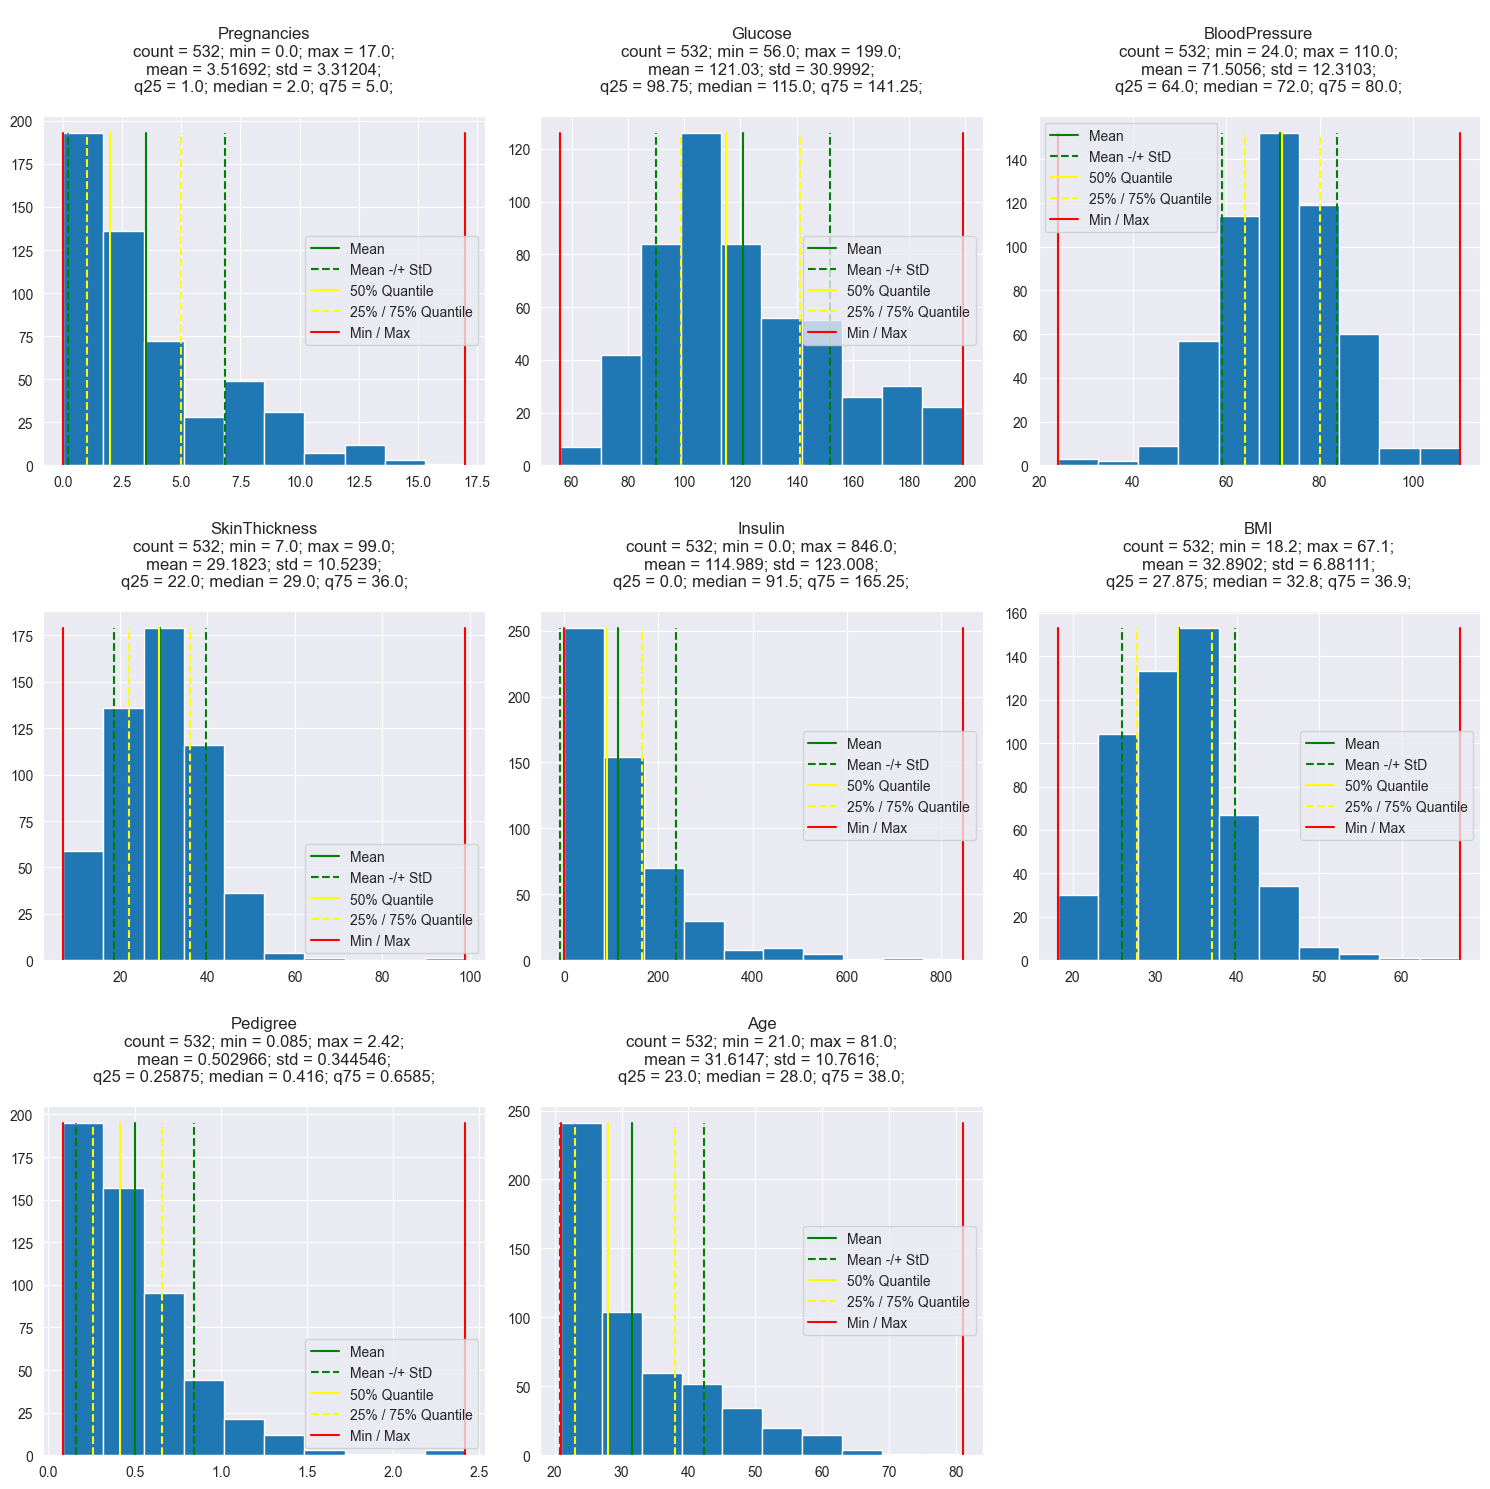

In [129]:
# Правило Стёрджиса для выбора оптимального количества интервалов в гистограмме 
def sturges(n):
    return int(1 + np.floor(np.log2(n)))

desc = data.describe()

num_rows = (len(desc.columns) + 2) // 3

fig = plt.figure(figsize=(15, num_rows * 5))

non_numeric_column_count = 0

for i, col in enumerate(desc.columns):
    if col == 'Outcome':
        non_numeric_column_count += 1
        continue

    ax = fig.add_subplot(num_rows, 3, i + 1 - non_numeric_column_count)

    bin_count = min(sturges(len(data[col])), len(data[col].unique()))

    hist = ax.hist(data[col], bins=bin_count)

    count = int(desc[col]['count'])
    mean = desc[col]['mean']
    std = desc[col]['std']
    min_val = desc[col]['min']
    max_val = desc[col]['max']
    q25 = desc[col]['25%']
    median = desc[col]['50%']
    q75 = desc[col]['75%']

    line_mean = ax.plot([mean, mean], [0, np.max(hist[0])], color='green', label='Mean')
    line_mean_minus_std = ax.plot([mean - std, mean - std], [0, np.max(hist[0])],
                                  color='green', linestyle='dashed', label='Mean -/+ StD ')
    line_mean_plus_std = ax.plot([mean + std, mean + std], [0, np.max(hist[0])],
                                 color='green', linestyle='dashed')
    line_median = ax.plot([median, median], [0, np.max(hist[0])],
                          color='yellow', label='50% Quantile')
    line_q25 = ax.plot([q25, q25], [0, np.max(hist[0])],
                       color='yellow', linestyle='dashed', label='25% / 75% Quantile')
    line_q75 = ax.plot([q75, q75], [0, np.max(hist[0])],
                       color='yellow', linestyle='dashed')
    line_min = ax.plot([min_val, min_val], [0, np.max(hist[0])], color='red', label='Min / Max')
    line_max = ax.plot([max_val, max_val], [0, np.max(hist[0])], color='red')

    ax.set_title(
        f"""
{col}
count = {count}; min = {min_val:.6}; max = {max_val:.6};
mean = {mean:.6}; std = {std:.6};
q25 = {q25:.6}; median = {median:.6}; q75 = {q75:.6};
"""
    )
    ax.legend()
    ax.plot()


fig.tight_layout()
plt.show()

#### 2.2. Корреляция признаков

Построим корреляционную матрицу признаков:

In [130]:
correlation_matrix = data.corr()
correlation_matrix

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Pedigree,Age,Outcome
Pregnancies,1.000000,0.125330,0.204663,0.095085,-0.006568,0.008576,0.007435,0.640747,0.252586
Glucose,0.125330,1.000000,0.219178,0.226590,0.459905,0.247079,0.165817,0.278907,0.503614
BloodPressure,0.204663,0.219178,1.000000,0.226072,0.007052,0.307357,0.008047,0.346939,0.183432
SkinThickness,0.095085,0.226590,0.226072,1.000000,0.126240,0.647422,0.118636,0.161336,0.254874
Insulin,-0.006568,0.459905,0.007052,0.126240,1.000000,0.191168,0.151531,0.081126,0.212204
BMI,0.008576,0.247079,0.307357,0.647422,0.191168,1.000000,0.151107,0.073438,0.300901
Pedigree,0.007435,0.165817,0.008047,0.118636,0.151531,0.151107,1.000000,0.071654,0.233074
Age,0.640747,0.278907,0.346939,0.161336,0.081126,0.073438,0.071654,1.000000,0.315097
Outcome,0.252586,0.503614,0.183432,0.254874,0.212204,0.300901,0.233074,0.315097,1.000000


и тепловую карту на её основе:

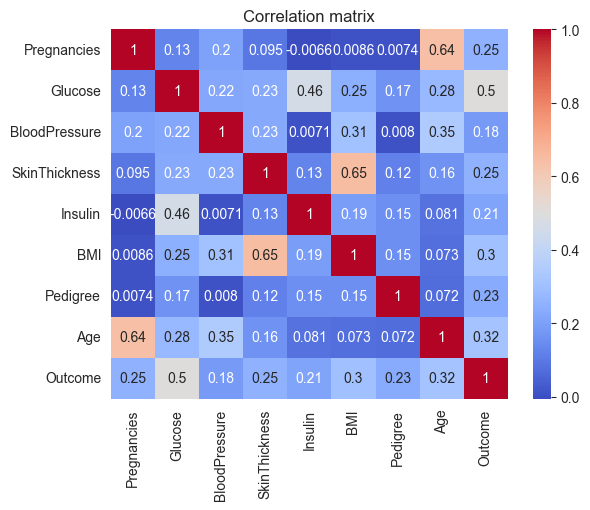

In [131]:
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

#### 2.3. 3D-визуализация признаков

Выбираем 3 случайных признака:

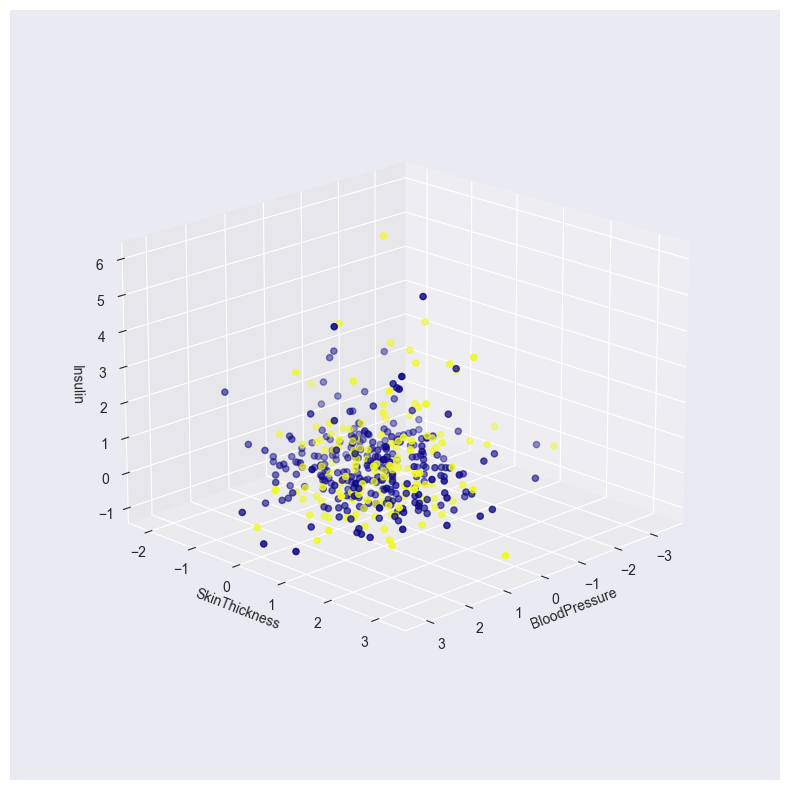

In [132]:
random_labels = train_x.sample(3, axis='columns')

x = random_labels.iloc[:, 0]
y = random_labels.iloc[:, 1]
z = random_labels.iloc[:, 2]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c=train_y, cmap='plasma')
ax.set_xlabel(random_labels.columns[0])
ax.set_ylabel(random_labels.columns[1])
ax.set_zlabel(random_labels.columns[2])
ax.view_init(elev=19.45, azim=45, roll=0)
ax.set_box_aspect(None, zoom=0.8)

fig.tight_layout()
plt.show()

Выбираем 3 фиксированных признака:

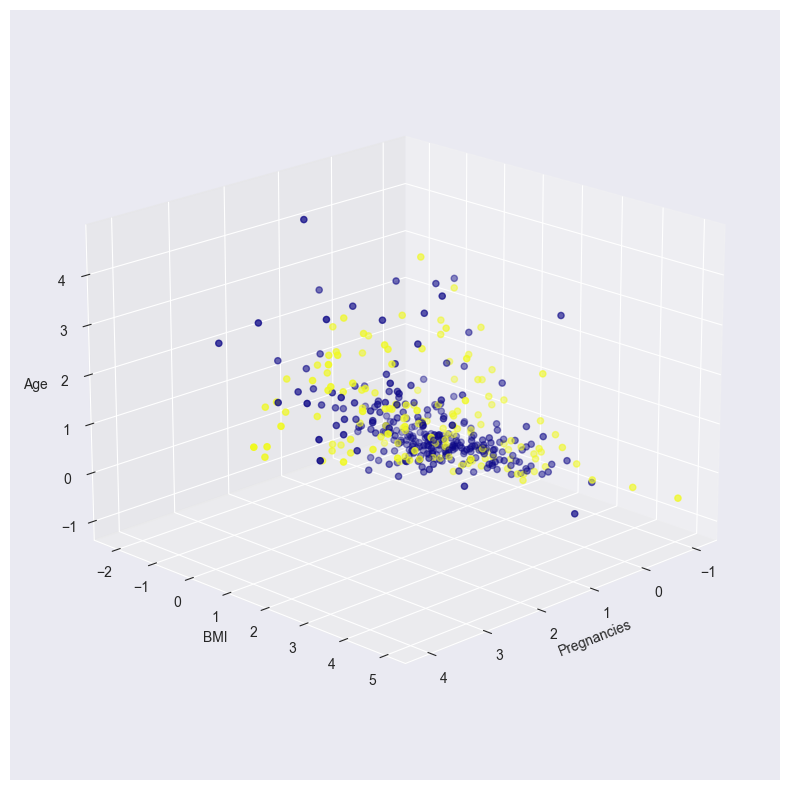

In [134]:
random_labels = train_x[['Pregnancies', 'BMI', 'Age']]

x = random_labels.iloc[:, 0]
y = random_labels.iloc[:, 1]
z = random_labels.iloc[:, 2]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c=train_y, cmap='plasma')
ax.set_xlabel(random_labels.columns[0])
ax.set_ylabel(random_labels.columns[1])
ax.set_zlabel(random_labels.columns[2])
ax.view_init(elev=19.45, azim=45, roll=0)
ax.set_box_aspect(None, zoom=0.9)

fig.tight_layout()
plt.show()

### 3. Реализация метода $k$-ближайших соседей (k-NN)

In [ ]:
def distance(x: np.ndarray, y: np.ndarray) -> np.float64:
    return np.linalg.norm((y - x), ord=2)